# Description

TODO

# Modules

Make sure we are not using multiple cores for this comparison.

In [1]:
# %env NUMBA_NUM_THREADS=1
# %env MKL_NUM_THREADS=1
# %env OPEN_BLAS_NUM_THREADS=1
# %env NUMEXPR_NUM_THREADS=1
# %env OMP_NUM_THREADS=1

In [2]:
from timeit import timeit

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

from clustermatch import conf
from clustermatch.coef import cm
from clustermatch.methods import mic, distcorr

# Settings

In [3]:
N_REPS = 10
N_SAMPLES_LIST = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

In [4]:
np.random.seed(0)

# Paths

In [5]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [6]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "intro"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/intro')

# Setup code

In [7]:
x = np.random.rand(100)
y = np.random.rand(100)

In [8]:
cm(x, y)

0.02047038824894002

In [9]:
mic(x, y)

0.24659336787668185

In [10]:
distcorr(x, y)

0.14483916338600375

In [11]:
def run_timeit(corr_func, x, y):
    results = []
    for i in range(N_REPS):
        results.append(timeit(lambda: corr_func(x, y), number=1))
    return results

# Run

In [12]:
n_samples_list = []

cm_times = []
mic_times = []
distcorr_times = []

In [13]:
for i, n_samples in enumerate(N_SAMPLES_LIST):
    x = np.random.rand(n_samples)
    y = np.random.rand(n_samples)

    cm_times.extend(run_timeit(cm, x, y))
    distcorr_times.extend(run_timeit(distcorr, x, y))

    if n_samples <= 10000:
        mic_times.extend(run_timeit(mic, x, y))
    else:
        mic_times.extend([np.nan] * N_REPS)

    n_samples_list.extend([n_samples] * N_REPS)

In [14]:
res = pd.DataFrame(
    {
        "n_samples": n_samples_list,
        "cm": cm_times,
        "dcor": distcorr_times,
        "mic": mic_times,
    }
)

In [15]:
res.shape

(90, 4)

In [16]:
res.head()

,n_samples,cm,dcor,mic
0,10,0.009944,0.000267,0.000047
1,10,0.000317,0.000200,0.000029
2,10,0.003539,0.000408,0.000027
3,10,0.000295,0.000198,0.000025
4,10,0.000307,0.000196,0.000025


In [17]:
res = pd.melt(res, id_vars=["n_samples"], var_name="method", value_name="time")

In [18]:
res.head()

,n_samples,method,time
0,10,cm,0.009944
1,10,cm,0.000317
2,10,cm,0.003539
3,10,cm,0.000295
4,10,cm,0.000307


# Plot

## Point plot

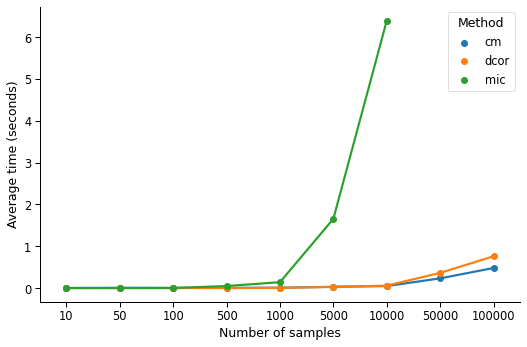

In [19]:
with sns.plotting_context("paper", font_scale=1.3):
    g = sns.catplot(
        data=res,
        x="n_samples",
        y="time",
        hue="method",
        kind="point",
        height=5,
        aspect=1.5,
        legend_out=False,
    )
    g.ax.set_xlabel("Number of samples")
    g.ax.set_ylabel("Average time (seconds)")
    g.legend.set_title("Method")

    plt.savefig(
        OUTPUT_FIGURE_DIR / "time-point_plot.svg",
        # rasterized=True,
        # dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

## Line plot

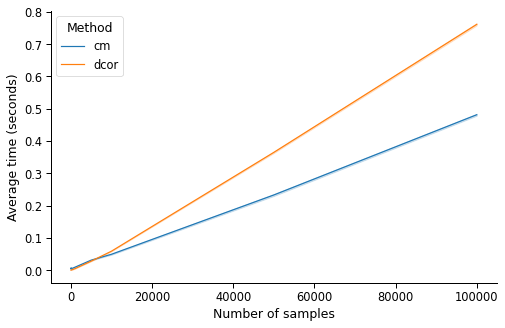

In [20]:
with sns.plotting_context("paper", font_scale=1.3):
    res_thin = res[~res["method"].isin(("mic",))]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax = sns.lineplot(data=res_thin, x="n_samples", y="time", hue="method", legend=True)
    sns.despine()
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("Average time (seconds)")
    ax.legend_.set_title("Method")

    plt.savefig(
        OUTPUT_FIGURE_DIR / "time-line_plot.svg",
        # rasterized=True,
        # dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )